## Шаг 0: Зависимости

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Шаг 1/2: Загрузка данных и Feature Engineering

Загрузка данных и Feature Engineering полностью идентичны. Мы используем уже созданный датафрейм final_feat как основу. 

In [97]:
# # Загрузка всех таблиц
# telemetry = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_telemetry.csv")
# errors = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_errors.csv")
# maint = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_maint.csv")
# failures = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_failures.csv")
# machines = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_machines.csv")

In [98]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [99]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [100]:
# Сводка по машинам и времени
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"])

# Усредняем по машинам и времени с шагом 3 часа
telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")

# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

# 3H признаки
temp_mean_3h, temp_std_3h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Ресемплируем до 3-часовых интервалов
    resampled = pt.resample('3H', closed='left', label='right')
    temp_mean_3h.append(resampled.mean().unstack())
    temp_std_3h.append(resampled.std().unstack())

telemetry_mean_3h = pd.concat(temp_mean_3h, axis=1)
telemetry_mean_3h.columns = [f"{col}mean_3h" for col in fields]

telemetry_sd_3h = pd.concat(temp_std_3h, axis=1)
telemetry_sd_3h.columns = [f"{col}sd_3h" for col in fields]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
telemetry_mean_3h = telemetry_mean_3h.reset_index()
telemetry_sd_3h = telemetry_sd_3h.reset_index()

# 24H признаки
temp_mean_24h, temp_std_24h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Скользящее окно 24 часа (24 записи при часовой частоте)
    rolling_mean = pt.rolling(window=24, min_periods=1).mean()
    rolling_std = pt.rolling(window=24, min_periods=1).std()
    # Ресемплируем каждые 3 часа, берём первое значение окна
    temp_mean_24h.append(rolling_mean.resample("3H", closed="left", label="right").first().unstack())
    temp_std_24h.append(rolling_std.resample("3H", closed="left", label="right").first().unstack())

telemetry_mean_24h = pd.concat(temp_mean_24h, axis=1)
telemetry_mean_24h.columns = [f"{col}mean_24h" for col in fields]
telemetry_mean_24h = telemetry_mean_24h.reset_index()

telemetry_sd_24h = pd.concat(temp_std_24h, axis=1)
telemetry_sd_24h.columns = [f"{col}sd_24h" for col in fields]
telemetry_sd_24h = telemetry_sd_24h.reset_index()

# Удаляем строки, где 24h статистика не определена (NaN)
telemetry_mean_24h = telemetry_mean_24h.dropna(subset=[f"{fields[0]}mean_24h"])
telemetry_sd_24h = telemetry_sd_24h.dropna(subset=[f"{fields[0]}sd_24h"])

# Объединение всех признаков
# Берём machineID и datetime из telemetry_mean_3h
telemetry_feat = telemetry_mean_3h.copy()

# Добавляем остальные признаки 
for df in [telemetry_sd_3h, telemetry_mean_24h, telemetry_sd_24h]:
    # Исключаем колонки machineID и datetime при слиянии
    telemetry_feat = telemetry_feat.merge(df, on=["machineID", "datetime"], how="inner")

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

In [101]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

In [102]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Применим StandardScaler только к FFT-признакам
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

In [103]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

In [104]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

# Вычисляем дни с последней замены для каждого компонента
comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

In [105]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 'model'
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,...,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,...,0.027671,0.027041,0.022877,0.019890,0.009753,53.464473,51.475866,52.660493,53.769068,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,...,0.167173,0.165278,0.152054,0.141355,0.099075,62.479594,59.251179,58.856793,59.692723,5.827625


## Шаг 3: Создание целевой переменной RUL и формирование датасета

In [106]:
def create_rul_dataset(failures_df, final_feat_df, window_hours=24):
    """
    Создает датасет для RUL-регрессии, используя окна перед каждым отказом.
    """
    rul_records = []
    final_feat_df = final_feat_df.copy()
    failures_df = failures_df.copy()
    
    # Приводим к datetime
    final_feat_df["datetime"] = pd.to_datetime(final_feat_df["datetime"])
    failures_df["datetime"] = pd.to_datetime(failures_df["datetime"])
    
    for _, failure_row in failures_df.iterrows():
        machine_id = failure_row["machineID"]
        failure_time = failure_row["datetime"]
        
        window_start = failure_time - pd.Timedelta(hours=window_hours)
        window_data = final_feat_df[
            (final_feat_df["machineID"] == machine_id) &
            (final_feat_df["datetime"] >= window_start) &
            (final_feat_df["datetime"] < failure_time)
        ].copy()
        
        if window_data.empty:
            continue
            
        # Рассчитываем RUL для каждой точки в окне в часах
        window_data["RUL"] = (failure_time - window_data["datetime"]).dt.total_seconds() / 3600.0
        rul_records.append(window_data)
    
    return pd.concat(rul_records, ignore_index=True)

# Создаём RUL-датасет
rul_dataset = create_rul_dataset(failures, final_feat, window_hours=24)

## Шаг 4: Разделение на обучающую и валидационную выборки (с учетом временного порядка)

Мы сохраняем предыдущий подход с временным сплитом.

In [107]:
# Разделяем по machineID
from sklearn.model_selection import train_test_split

# Получаем уникальные ID машин, у которых были отказы
mids_with_failures = rul_dataset["machineID"].unique()

# Делим ID машин на трейн и валидацию (80/20)
train_mids, val_mids = train_test_split(
    mids_with_failures, 
    test_size=0.2, 
    random_state=42
)

# Создаем маски
train_mask = rul_dataset["machineID"].isin(train_mids)
val_mask = rul_dataset["machineID"].isin(val_mids)

# Проверяем, что валидационный набор не пуст
if val_mask.sum() == 0:
    raise ValueError("val_mask.sum():", val_mask.sum())

# Разделяем признаки и целевую переменную
feature_columns = [col for col in rul_dataset.columns if col not in ["datetime", "machineID", "RUL"]]
X = rul_dataset[feature_columns]
y = rul_dataset["RUL"]

X_train = X.loc[train_mask].values
y_train = y.loc[train_mask].values

X_val = X.loc[val_mask].values
y_val = y.loc[val_mask].values

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}")
print(f"Train RUL range: [{y_train.min():.1f}, {y_train.max():.1f}] hours")

Train samples: 4900, Val samples: 1149
Train RUL range: [3.0, 24.0] hours


## Шаг 5: Нормализация признаков

In [108]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Подготовка тензоров
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=256, shuffle=False)

input_size = X_train.shape[1]

## Шаг 6: Определение моделей для RUL-регрессии

Добавим простую MLP (Multi-Layer Perceptron) в качестве бейзлайна для сравнения.

In [109]:
class DLinearRegressor(nn.Module):
    def __init__(self, input_size, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear_trend = nn.Linear(input_size, 1)
        self.linear_seasonal = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.dropout(x)
        # Сумма вкладов от обеих компонент
        out = self.linear_trend(x) + self.linear_seasonal(x)
        return out.squeeze(-1)  # (B,) для регрессии


class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

## Шаг 7: Обучение моделей

In [110]:
class ValueMeter(object):
    """
    Вспомогательный класс, чтобы отслеживать loss и метрику
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.total = 0

    def add(self, value, n=1):
        self.sum += value * n
        self.total += n

    def value(self):
        return self.sum / self.total if self.total > 0 else float('nan')

def log(mode, epoch, loss_meter, f1_meter):
    """
    Логирует loss и accuracy 
    """
    print(
        f'[{mode}] Epoch: {epoch+1:02d}. '
        f'Loss: {loss_meter.value():.4f}. '
        f'F1: {100 * f1_meter.value():.2f}%'
    )

In [111]:
def Evaluate(model, train_loader, val_loader, epochs=100, y_train=None):
    """
    Универсальный цикл обучения для RUL-регрессии.
    """
    device = next(model.parameters()).device
    model.to(device)
    
    # MSE 
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    best_val_mae = float('inf')
    patience = 15
    counter = 0
    best_model_state = copy.deepcopy(model.state_dict())
    
    train_mae_history, val_mae_history = [], []
    train_loss_history, val_loss_history = [], []
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter = ValueMeter()
        train_mae_meter = ValueMeter()
        
        for X, y in tqdm(train_loader, desc=f"Train RUL {epoch+1}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss_meter.add(loss.item(), X.size(0))
            mae = torch.mean(torch.abs(out - y)).item()
            train_mae_meter.add(mae, X.size(0))
        
        train_mae_history.append(train_mae_meter.value())
        train_loss_history.append(train_loss_meter.value())
        
        # Валидация
        model.eval()
        val_loss_meter = ValueMeter()
        val_mae_meter = ValueMeter()
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss_meter.add(loss.item(), X.size(0))
                mae = torch.mean(torch.abs(out - y)).item()
                val_mae_meter.add(mae, X.size(0))
        
        val_mae = val_mae_meter.value()
        val_mae_history.append(val_mae)
        val_loss_history.append(val_loss_meter.value())
        
        print(f"[RUL] Epoch {epoch+1}. Train MAE: {train_mae_meter.value():.2f}, Val MAE: {val_mae:.2f}")
        
        # Early Stopping на основе MAE 
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping on epoch {epoch+1}")
                break
                
    model.load_state_dict(best_model_state)
    
    # Финальное предсказание на валидации
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            out = model(X)
            y_pred_list.append(out.cpu().numpy())
    y_pred = np.concatenate(y_pred_list, axis=0)
    
    return y_pred, {
        'best_val_mae': best_val_mae,
        'train_mae': train_mae_history,
        'val_mae': val_mae_history,
        'train_loss': train_loss_history,
        'val_loss': val_loss_history
    }

## Шаг 8: Обучение моделей

In [112]:
# Обучение DLinear
dlinear_rul = DLinearRegressor(input_size=input_size, dropout=0.1).to(device)
y_pred_dlinear, history_dlinear = Evaluate(
    dlinear_rul, train_loader, val_loader, epochs=100, y_train=y_train
)

Train RUL 1:   0%|          | 0/20 [00:00<?, ?it/s]

Train RUL 1: 100%|██████████| 20/20 [00:00<00:00, 272.39it/s]


[RUL] Epoch 1. Train MAE: 13.48, Val MAE: 13.53


Train RUL 2: 100%|██████████| 20/20 [00:00<00:00, 1244.12it/s]


[RUL] Epoch 2. Train MAE: 13.43, Val MAE: 13.49


Train RUL 3: 100%|██████████| 20/20 [00:00<00:00, 1326.79it/s]


[RUL] Epoch 3. Train MAE: 13.39, Val MAE: 13.45


Train RUL 4: 100%|██████████| 20/20 [00:00<00:00, 1286.77it/s]


[RUL] Epoch 4. Train MAE: 13.35, Val MAE: 13.41


Train RUL 5: 100%|██████████| 20/20 [00:00<00:00, 1322.50it/s]


[RUL] Epoch 5. Train MAE: 13.31, Val MAE: 13.36


Train RUL 6: 100%|██████████| 20/20 [00:00<00:00, 1387.42it/s]


[RUL] Epoch 6. Train MAE: 13.27, Val MAE: 13.32


Train RUL 7: 100%|██████████| 20/20 [00:00<00:00, 1223.33it/s]


[RUL] Epoch 7. Train MAE: 13.22, Val MAE: 13.28


Train RUL 8: 100%|██████████| 20/20 [00:00<00:00, 1389.85it/s]


[RUL] Epoch 8. Train MAE: 13.18, Val MAE: 13.24


Train RUL 9: 100%|██████████| 20/20 [00:00<00:00, 1371.65it/s]


[RUL] Epoch 9. Train MAE: 13.15, Val MAE: 13.20


Train RUL 10: 100%|██████████| 20/20 [00:00<00:00, 1261.92it/s]


[RUL] Epoch 10. Train MAE: 13.11, Val MAE: 13.16


Train RUL 11: 100%|██████████| 20/20 [00:00<00:00, 1384.49it/s]


[RUL] Epoch 11. Train MAE: 13.07, Val MAE: 13.12


Train RUL 12: 100%|██████████| 20/20 [00:00<00:00, 1313.02it/s]


[RUL] Epoch 12. Train MAE: 13.03, Val MAE: 13.08


Train RUL 13: 100%|██████████| 20/20 [00:00<00:00, 1294.16it/s]


[RUL] Epoch 13. Train MAE: 12.99, Val MAE: 13.04


Train RUL 14: 100%|██████████| 20/20 [00:00<00:00, 1356.22it/s]


[RUL] Epoch 14. Train MAE: 12.95, Val MAE: 12.99


Train RUL 15: 100%|██████████| 20/20 [00:00<00:00, 1379.68it/s]


[RUL] Epoch 15. Train MAE: 12.91, Val MAE: 12.95


Train RUL 16: 100%|██████████| 20/20 [00:00<00:00, 1318.13it/s]


[RUL] Epoch 16. Train MAE: 12.87, Val MAE: 12.91


Train RUL 17: 100%|██████████| 20/20 [00:00<00:00, 1341.73it/s]


[RUL] Epoch 17. Train MAE: 12.83, Val MAE: 12.87


Train RUL 18: 100%|██████████| 20/20 [00:00<00:00, 1325.03it/s]


[RUL] Epoch 18. Train MAE: 12.80, Val MAE: 12.84


Train RUL 19: 100%|██████████| 20/20 [00:00<00:00, 1390.13it/s]


[RUL] Epoch 19. Train MAE: 12.76, Val MAE: 12.79


Train RUL 20: 100%|██████████| 20/20 [00:00<00:00, 1392.55it/s]


[RUL] Epoch 20. Train MAE: 12.71, Val MAE: 12.75


Train RUL 21: 100%|██████████| 20/20 [00:00<00:00, 1277.70it/s]


[RUL] Epoch 21. Train MAE: 12.67, Val MAE: 12.71


Train RUL 22: 100%|██████████| 20/20 [00:00<00:00, 1331.21it/s]


[RUL] Epoch 22. Train MAE: 12.63, Val MAE: 12.67


Train RUL 23: 100%|██████████| 20/20 [00:00<00:00, 1398.99it/s]


[RUL] Epoch 23. Train MAE: 12.60, Val MAE: 12.63


Train RUL 24: 100%|██████████| 20/20 [00:00<00:00, 1405.48it/s]


[RUL] Epoch 24. Train MAE: 12.56, Val MAE: 12.59


Train RUL 25: 100%|██████████| 20/20 [00:00<00:00, 1415.82it/s]


[RUL] Epoch 25. Train MAE: 12.52, Val MAE: 12.55


Train RUL 26: 100%|██████████| 20/20 [00:00<00:00, 1377.98it/s]


[RUL] Epoch 26. Train MAE: 12.47, Val MAE: 12.51


Train RUL 27: 100%|██████████| 20/20 [00:00<00:00, 1373.43it/s]


[RUL] Epoch 27. Train MAE: 12.44, Val MAE: 12.47


Train RUL 28: 100%|██████████| 20/20 [00:00<00:00, 1319.63it/s]


[RUL] Epoch 28. Train MAE: 12.40, Val MAE: 12.43


Train RUL 29: 100%|██████████| 20/20 [00:00<00:00, 1347.61it/s]


[RUL] Epoch 29. Train MAE: 12.35, Val MAE: 12.39


Train RUL 30: 100%|██████████| 20/20 [00:00<00:00, 1378.93it/s]


[RUL] Epoch 30. Train MAE: 12.32, Val MAE: 12.35


Train RUL 31: 100%|██████████| 20/20 [00:00<00:00, 1362.21it/s]


[RUL] Epoch 31. Train MAE: 12.28, Val MAE: 12.31


Train RUL 32: 100%|██████████| 20/20 [00:00<00:00, 1369.12it/s]


[RUL] Epoch 32. Train MAE: 12.24, Val MAE: 12.27


Train RUL 33: 100%|██████████| 20/20 [00:00<00:00, 1308.39it/s]


[RUL] Epoch 33. Train MAE: 12.21, Val MAE: 12.23


Train RUL 34: 100%|██████████| 20/20 [00:00<00:00, 1288.83it/s]


[RUL] Epoch 34. Train MAE: 12.16, Val MAE: 12.19


Train RUL 35: 100%|██████████| 20/20 [00:00<00:00, 1380.55it/s]


[RUL] Epoch 35. Train MAE: 12.12, Val MAE: 12.15


Train RUL 36: 100%|██████████| 20/20 [00:00<00:00, 1401.82it/s]


[RUL] Epoch 36. Train MAE: 12.08, Val MAE: 12.11


Train RUL 37: 100%|██████████| 20/20 [00:00<00:00, 1409.23it/s]


[RUL] Epoch 37. Train MAE: 12.04, Val MAE: 12.07


Train RUL 38: 100%|██████████| 20/20 [00:00<00:00, 1401.54it/s]


[RUL] Epoch 38. Train MAE: 12.00, Val MAE: 12.04


Train RUL 39: 100%|██████████| 20/20 [00:00<00:00, 1389.26it/s]


[RUL] Epoch 39. Train MAE: 11.97, Val MAE: 12.00


Train RUL 40: 100%|██████████| 20/20 [00:00<00:00, 378.82it/s]


[RUL] Epoch 40. Train MAE: 11.92, Val MAE: 11.96


Train RUL 41: 100%|██████████| 20/20 [00:00<00:00, 1375.70it/s]


[RUL] Epoch 41. Train MAE: 11.88, Val MAE: 11.92


Train RUL 42: 100%|██████████| 20/20 [00:00<00:00, 1383.62it/s]


[RUL] Epoch 42. Train MAE: 11.85, Val MAE: 11.88


Train RUL 43: 100%|██████████| 20/20 [00:00<00:00, 1415.32it/s]


[RUL] Epoch 43. Train MAE: 11.81, Val MAE: 11.84


Train RUL 44: 100%|██████████| 20/20 [00:00<00:00, 1319.42it/s]


[RUL] Epoch 44. Train MAE: 11.78, Val MAE: 11.80


Train RUL 45: 100%|██████████| 20/20 [00:00<00:00, 1400.08it/s]


[RUL] Epoch 45. Train MAE: 11.74, Val MAE: 11.76


Train RUL 46: 100%|██████████| 20/20 [00:00<00:00, 1390.34it/s]


[RUL] Epoch 46. Train MAE: 11.70, Val MAE: 11.73


Train RUL 47: 100%|██████████| 20/20 [00:00<00:00, 1377.98it/s]


[RUL] Epoch 47. Train MAE: 11.66, Val MAE: 11.69


Train RUL 48: 100%|██████████| 20/20 [00:00<00:00, 1399.41it/s]


[RUL] Epoch 48. Train MAE: 11.62, Val MAE: 11.65


Train RUL 49: 100%|██████████| 20/20 [00:00<00:00, 1402.21it/s]


[RUL] Epoch 49. Train MAE: 11.57, Val MAE: 11.61


Train RUL 50: 100%|██████████| 20/20 [00:00<00:00, 1398.03it/s]


[RUL] Epoch 50. Train MAE: 11.54, Val MAE: 11.58


Train RUL 51: 100%|██████████| 20/20 [00:00<00:00, 1197.91it/s]


[RUL] Epoch 51. Train MAE: 11.51, Val MAE: 11.54


Train RUL 52: 100%|██████████| 20/20 [00:00<00:00, 1217.43it/s]


[RUL] Epoch 52. Train MAE: 11.46, Val MAE: 11.50


Train RUL 53: 100%|██████████| 20/20 [00:00<00:00, 1341.19it/s]


[RUL] Epoch 53. Train MAE: 11.42, Val MAE: 11.46


Train RUL 54: 100%|██████████| 20/20 [00:00<00:00, 1346.98it/s]


[RUL] Epoch 54. Train MAE: 11.39, Val MAE: 11.43


Train RUL 55: 100%|██████████| 20/20 [00:01<00:00, 13.99it/s]


[RUL] Epoch 55. Train MAE: 11.35, Val MAE: 11.39


Train RUL 56: 100%|██████████| 20/20 [00:00<00:00, 1300.22it/s]


[RUL] Epoch 56. Train MAE: 11.31, Val MAE: 11.35


Train RUL 57: 100%|██████████| 20/20 [00:00<00:00, 1283.13it/s]


[RUL] Epoch 57. Train MAE: 11.27, Val MAE: 11.32


Train RUL 58: 100%|██████████| 20/20 [00:00<00:00, 1194.94it/s]


[RUL] Epoch 58. Train MAE: 11.24, Val MAE: 11.28


Train RUL 59: 100%|██████████| 20/20 [00:00<00:00, 1357.49it/s]


[RUL] Epoch 59. Train MAE: 11.20, Val MAE: 11.24


Train RUL 60: 100%|██████████| 20/20 [00:00<00:00, 1344.37it/s]


[RUL] Epoch 60. Train MAE: 11.17, Val MAE: 11.21


Train RUL 61: 100%|██████████| 20/20 [00:00<00:00, 1283.70it/s]


[RUL] Epoch 61. Train MAE: 11.13, Val MAE: 11.17


Train RUL 62: 100%|██████████| 20/20 [00:00<00:00, 1175.24it/s]


[RUL] Epoch 62. Train MAE: 11.09, Val MAE: 11.13


Train RUL 63: 100%|██████████| 20/20 [00:00<00:00, 1361.54it/s]


[RUL] Epoch 63. Train MAE: 11.05, Val MAE: 11.10


Train RUL 64: 100%|██████████| 20/20 [00:00<00:00, 1362.85it/s]


[RUL] Epoch 64. Train MAE: 11.02, Val MAE: 11.06


Train RUL 65: 100%|██████████| 20/20 [00:00<00:00, 1300.22it/s]


[RUL] Epoch 65. Train MAE: 10.98, Val MAE: 11.03


Train RUL 66: 100%|██████████| 20/20 [00:00<00:00, 1347.89it/s]


[RUL] Epoch 66. Train MAE: 10.96, Val MAE: 10.99


Train RUL 67: 100%|██████████| 20/20 [00:00<00:00, 1359.27it/s]


[RUL] Epoch 67. Train MAE: 10.91, Val MAE: 10.95


Train RUL 68: 100%|██████████| 20/20 [00:00<00:00, 1337.70it/s]


[RUL] Epoch 68. Train MAE: 10.88, Val MAE: 10.92


Train RUL 69: 100%|██████████| 20/20 [00:00<00:00, 1278.44it/s]


[RUL] Epoch 69. Train MAE: 10.83, Val MAE: 10.88


Train RUL 70: 100%|██████████| 20/20 [00:00<00:00, 1351.54it/s]


[RUL] Epoch 70. Train MAE: 10.81, Val MAE: 10.85


Train RUL 71: 100%|██████████| 20/20 [00:00<00:00, 1357.58it/s]


[RUL] Epoch 71. Train MAE: 10.77, Val MAE: 10.81


Train RUL 72: 100%|██████████| 20/20 [00:00<00:00, 1334.94it/s]


[RUL] Epoch 72. Train MAE: 10.74, Val MAE: 10.78


Train RUL 73: 100%|██████████| 20/20 [00:00<00:00, 1375.88it/s]


[RUL] Epoch 73. Train MAE: 10.70, Val MAE: 10.74


Train RUL 74: 100%|██████████| 20/20 [00:00<00:00, 1352.52it/s]


[RUL] Epoch 74. Train MAE: 10.67, Val MAE: 10.71


Train RUL 75: 100%|██████████| 20/20 [00:00<00:00, 1381.59it/s]


[RUL] Epoch 75. Train MAE: 10.63, Val MAE: 10.67


Train RUL 76: 100%|██████████| 20/20 [00:00<00:00, 288.76it/s]


[RUL] Epoch 76. Train MAE: 10.59, Val MAE: 10.64


Train RUL 77: 100%|██████████| 20/20 [00:00<00:00, 610.02it/s]


[RUL] Epoch 77. Train MAE: 10.56, Val MAE: 10.60


Train RUL 78: 100%|██████████| 20/20 [00:00<00:00, 1320.40it/s]


[RUL] Epoch 78. Train MAE: 10.52, Val MAE: 10.57


Train RUL 79: 100%|██████████| 20/20 [00:00<00:00, 1368.92it/s]


[RUL] Epoch 79. Train MAE: 10.49, Val MAE: 10.53


Train RUL 80: 100%|██████████| 20/20 [00:00<00:00, 1394.59it/s]


[RUL] Epoch 80. Train MAE: 10.46, Val MAE: 10.50


Train RUL 81: 100%|██████████| 20/20 [00:00<00:00, 1396.57it/s]


[RUL] Epoch 81. Train MAE: 10.42, Val MAE: 10.46


Train RUL 82: 100%|██████████| 20/20 [00:00<00:00, 1417.14it/s]


[RUL] Epoch 82. Train MAE: 10.39, Val MAE: 10.43


Train RUL 83: 100%|██████████| 20/20 [00:00<00:00, 1404.77it/s]


[RUL] Epoch 83. Train MAE: 10.35, Val MAE: 10.40


Train RUL 84: 100%|██████████| 20/20 [00:00<00:00, 1386.48it/s]


[RUL] Epoch 84. Train MAE: 10.32, Val MAE: 10.36


Train RUL 85: 100%|██████████| 20/20 [00:00<00:00, 1355.01it/s]


[RUL] Epoch 85. Train MAE: 10.28, Val MAE: 10.33


Train RUL 86: 100%|██████████| 20/20 [00:00<00:00, 1354.84it/s]


[RUL] Epoch 86. Train MAE: 10.25, Val MAE: 10.30


Train RUL 87: 100%|██████████| 20/20 [00:00<00:00, 1376.94it/s]


[RUL] Epoch 87. Train MAE: 10.22, Val MAE: 10.26


Train RUL 88: 100%|██████████| 20/20 [00:00<00:00, 1365.07it/s]


[RUL] Epoch 88. Train MAE: 10.19, Val MAE: 10.23


Train RUL 89: 100%|██████████| 20/20 [00:00<00:00, 1391.21it/s]


[RUL] Epoch 89. Train MAE: 10.15, Val MAE: 10.20


Train RUL 90: 100%|██████████| 20/20 [00:00<00:00, 1384.94it/s]


[RUL] Epoch 90. Train MAE: 10.12, Val MAE: 10.16


Train RUL 91: 100%|██████████| 20/20 [00:00<00:00, 1383.89it/s]


[RUL] Epoch 91. Train MAE: 10.08, Val MAE: 10.13


Train RUL 92: 100%|██████████| 20/20 [00:00<00:00, 1367.60it/s]


[RUL] Epoch 92. Train MAE: 10.06, Val MAE: 10.10


Train RUL 93: 100%|██████████| 20/20 [00:00<00:00, 1389.00it/s]


[RUL] Epoch 93. Train MAE: 10.02, Val MAE: 10.07


Train RUL 94: 100%|██████████| 20/20 [00:00<00:00, 1405.57it/s]


[RUL] Epoch 94. Train MAE: 9.98, Val MAE: 10.03


Train RUL 95: 100%|██████████| 20/20 [00:00<00:00, 1369.19it/s]


[RUL] Epoch 95. Train MAE: 9.96, Val MAE: 10.00


Train RUL 96: 100%|██████████| 20/20 [00:00<00:00, 1307.86it/s]


[RUL] Epoch 96. Train MAE: 9.93, Val MAE: 9.97


Train RUL 97: 100%|██████████| 20/20 [00:00<00:00, 1392.46it/s]


[RUL] Epoch 97. Train MAE: 9.89, Val MAE: 9.94


Train RUL 98: 100%|██████████| 20/20 [00:00<00:00, 1351.80it/s]


[RUL] Epoch 98. Train MAE: 9.88, Val MAE: 9.91


Train RUL 99: 100%|██████████| 20/20 [00:00<00:00, 1380.75it/s]


[RUL] Epoch 99. Train MAE: 9.82, Val MAE: 9.87


Train RUL 100: 100%|██████████| 20/20 [00:00<00:00, 1390.15it/s]


[RUL] Epoch 100. Train MAE: 9.79, Val MAE: 9.84


In [113]:
# Обучение MLP для сравнения
mlp_rul = MLPRegressor(input_size=input_size, hidden_size=128, dropout=0.3).to(device)
y_pred_mlp, history_mlp = Evaluate(
    mlp_rul, train_loader, val_loader, epochs=100, y_train=y_train
)

Train RUL 1: 100%|██████████| 20/20 [00:00<00:00, 632.17it/s]


[RUL] Epoch 1. Train MAE: 12.69, Val MAE: 11.67


Train RUL 2: 100%|██████████| 20/20 [00:00<00:00, 997.07it/s]


[RUL] Epoch 2. Train MAE: 10.48, Val MAE: 9.04


Train RUL 3: 100%|██████████| 20/20 [00:00<00:00, 984.98it/s]


[RUL] Epoch 3. Train MAE: 7.88, Val MAE: 6.60


Train RUL 4: 100%|██████████| 20/20 [00:00<00:00, 997.75it/s]


[RUL] Epoch 4. Train MAE: 6.41, Val MAE: 6.11


Train RUL 5: 100%|██████████| 20/20 [00:00<00:00, 1012.97it/s]


[RUL] Epoch 5. Train MAE: 6.15, Val MAE: 6.04


Train RUL 6: 100%|██████████| 20/20 [00:00<00:00, 995.72it/s]


[RUL] Epoch 6. Train MAE: 6.04, Val MAE: 6.01


Train RUL 7: 100%|██████████| 20/20 [00:00<00:00, 994.92it/s]

[RUL] Epoch 7. Train MAE: 5.96, Val MAE: 6.00



Train RUL 8: 100%|██████████| 20/20 [00:00<00:00, 1010.57it/s]


[RUL] Epoch 8. Train MAE: 5.95, Val MAE: 5.99


Train RUL 9: 100%|██████████| 20/20 [00:00<00:00, 344.09it/s]


[RUL] Epoch 9. Train MAE: 5.94, Val MAE: 6.00


Train RUL 10: 100%|██████████| 20/20 [00:00<00:00, 993.79it/s]


[RUL] Epoch 10. Train MAE: 5.88, Val MAE: 5.99


Train RUL 11: 100%|██████████| 20/20 [00:00<00:00, 971.86it/s]


[RUL] Epoch 11. Train MAE: 5.83, Val MAE: 5.99


Train RUL 12: 100%|██████████| 20/20 [00:00<00:00, 990.10it/s]


[RUL] Epoch 12. Train MAE: 5.85, Val MAE: 5.99


Train RUL 13: 100%|██████████| 20/20 [00:00<00:00, 1005.88it/s]


[RUL] Epoch 13. Train MAE: 5.82, Val MAE: 5.99


Train RUL 14: 100%|██████████| 20/20 [00:00<00:00, 1003.12it/s]


[RUL] Epoch 14. Train MAE: 5.75, Val MAE: 6.00


Train RUL 15: 100%|██████████| 20/20 [00:00<00:00, 1005.12it/s]


[RUL] Epoch 15. Train MAE: 5.78, Val MAE: 6.00


Train RUL 16: 100%|██████████| 20/20 [00:00<00:00, 998.16it/s]


[RUL] Epoch 16. Train MAE: 5.76, Val MAE: 6.01


Train RUL 17: 100%|██████████| 20/20 [00:00<00:00, 1003.31it/s]


[RUL] Epoch 17. Train MAE: 5.76, Val MAE: 6.01


Train RUL 18: 100%|██████████| 20/20 [00:00<00:00, 1000.99it/s]


[RUL] Epoch 18. Train MAE: 5.69, Val MAE: 6.00


Train RUL 19: 100%|██████████| 20/20 [00:00<00:00, 1003.47it/s]


[RUL] Epoch 19. Train MAE: 5.73, Val MAE: 6.00


Train RUL 20: 100%|██████████| 20/20 [00:00<00:00, 854.38it/s]


[RUL] Epoch 20. Train MAE: 5.73, Val MAE: 6.00


Train RUL 21: 100%|██████████| 20/20 [00:00<00:00, 933.65it/s]


[RUL] Epoch 21. Train MAE: 5.67, Val MAE: 6.00


Train RUL 22: 100%|██████████| 20/20 [00:00<00:00, 933.65it/s]


[RUL] Epoch 22. Train MAE: 5.69, Val MAE: 6.00


Train RUL 23: 100%|██████████| 20/20 [00:00<00:00, 941.22it/s]


[RUL] Epoch 23. Train MAE: 5.65, Val MAE: 6.00


Train RUL 24: 100%|██████████| 20/20 [00:00<00:00, 945.61it/s]


[RUL] Epoch 24. Train MAE: 5.63, Val MAE: 6.00


Train RUL 25: 100%|██████████| 20/20 [00:00<00:00, 948.54it/s]


[RUL] Epoch 25. Train MAE: 5.66, Val MAE: 6.02
Early stopping on epoch 25


## Шаг 9: Оценка и визуализация результатов

In [114]:
def print_rul_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} RUL Metrics:")
    print(f"MAE: {mae:.2f} hours")
    print(f"RMSE: {rmse:.2f} hours")
    print(f"R^2: {r2:.4f}")

print_rul_metrics(y_val, y_pred_dlinear, "DLinear")
print_rul_metrics(y_val, y_pred_mlp, "MLP")


DLinear RUL Metrics:
MAE: 9.84 hours
RMSE: 11.82 hours
R^2: -1.9625

MLP RUL Metrics:
MAE: 5.99 hours
RMSE: 6.96 hours
R^2: -0.0287


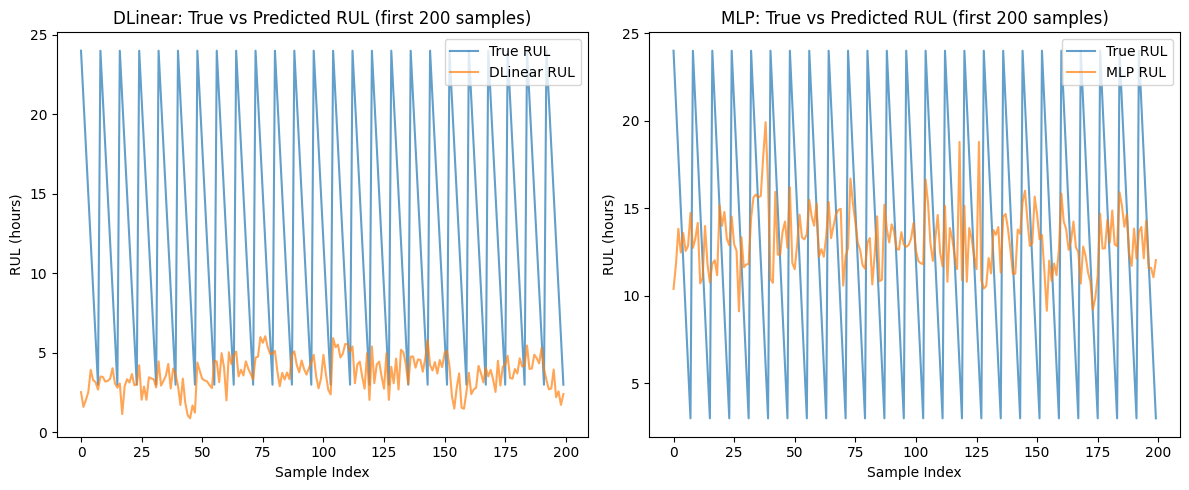

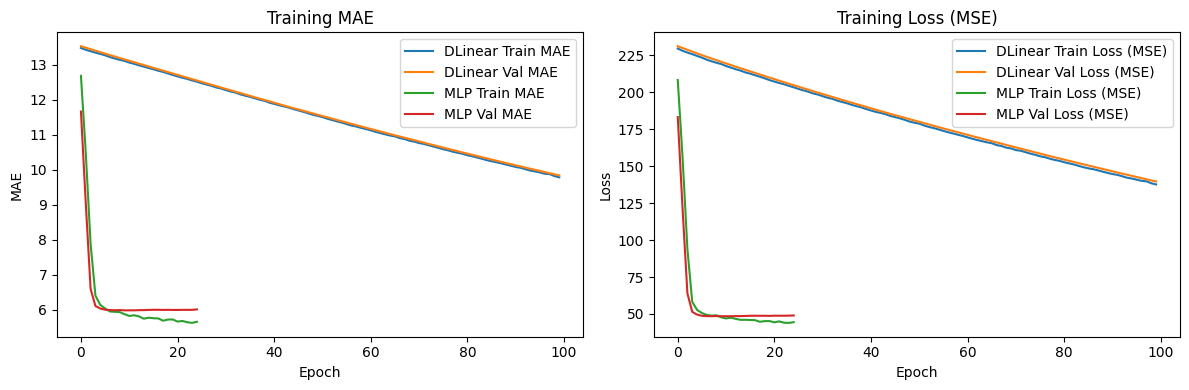

In [115]:
# Визуализация: График истинного RUL vs Предсказанного (для первых 200 точек)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_val[:200], label='True RUL', alpha=0.7)
plt.plot(y_pred_dlinear[:200], label='DLinear RUL', alpha=0.7)
plt.title('DLinear: True vs Predicted RUL (first 200 samples)')
plt.xlabel('Sample Index')
plt.ylabel('RUL (hours)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_val[:200], label='True RUL', alpha=0.7)
plt.plot(y_pred_mlp[:200], label='MLP RUL', alpha=0.7)
plt.title('MLP: True vs Predicted RUL (first 200 samples)')
plt.xlabel('Sample Index')
plt.ylabel('RUL (hours)')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация: График обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dlinear['train_mae'], label='DLinear Train MAE')
plt.plot(history_dlinear['val_mae'], label='DLinear Val MAE')
plt.plot(history_mlp['train_mae'], label='MLP Train MAE')
plt.plot(history_mlp['val_mae'], label='MLP Val MAE')
plt.title('Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dlinear['train_loss'], label='DLinear Train Loss (MSE)')
plt.plot(history_dlinear['val_loss'], label='DLinear Val Loss (MSE)')
plt.plot(history_mlp['train_loss'], label='MLP Train Loss (MSE)')
plt.plot(history_mlp['val_loss'], label='MLP Val Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()